<h1> Pneumonia classification </h1>

<h3> Imports </h3>

In [1]:
from keras.applications import VGG16
from keras import models, layers, optimizers, regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from pathlib import Path
import os, shutil
import numpy as np
from skimage import exposure,color,io,transform,filters,util
from keras import backend as K

Using TensorFlow backend.


<h3> Data directories </h3>

In [2]:
data_dir = Path('D:/DATASETS/PNEUMONIA')

train_dir = data_dir / 'train'

val_dir = data_dir / 'validation'

test_dir = data_dir / 'test'

<h4> Separo los tipos de pneumonia en carpetas diferentes </h4>

In [3]:
# directories = [train_dir, val_dir, test_dir]

# for direct in directories:
    
#     for fname in os.listdir(direct / 'PNEUMONIA'):

#         src = direct / 'PNEUMONIA' / fname

#         if 'bacteria' in fname:

#             dst = direct / 'BACTERIA' / fname
#             shutil.copyfile(src,dst)

#         if 'virus' in fname:

#             dst = direct / 'VIRUS' / fname
#             shutil.copyfile(src,dst)

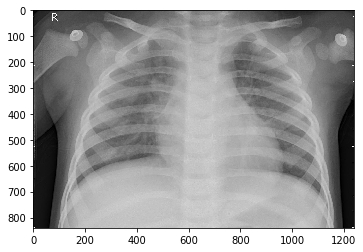

In [4]:
import matplotlib.image as mpimg
#train_dir / 'BACTERIA' / 'person1_bacteria_2.JPEG'
img=mpimg.imread(train_dir / 'BACTERIA' / 'person1_bacteria_2.JPEG')
plt.imshow(img, cmap='gray')

<h4> Creo una función para procesar las imagenes </h4>

In [5]:
def procesar_imagenes_gray(image):

    image = image * 1/255
    #Adding sharpness
    image = filters.unsharp_mask(image, radius=10)
        
    #Gamma-correction
    gamma = 1.1
    gain = 1
    image = exposure.adjust_gamma(image, gamma, gain)
    
    
    return image

(840, 1240)
1.0


array([[0.04850979, 0.04175068, 0.04125566, ..., 0.11307554, 0.12036947,
        0.12760496],
       [0.03530145, 0.02875013, 0.02827124, ..., 0.12706527, 0.13443534,
        0.13453579],
       [0.02227162, 0.02203654, 0.01556618, ..., 0.14095458, 0.13395264,
        0.13405351],
       ...,
       [0.09182728, 0.11310998, 0.01411402, ..., 0.        , 0.06589768,
        0.05893949],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.03770643, 0.        , ..., 0.        , 0.03876803,
        0.        ]])

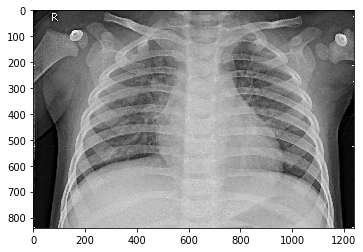

In [6]:
img2 = procesar_imagenes_gray(img)
plt.imshow(img2, cmap='gray')
print(img2.shape)
print(np.max(img2))
img2

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=procesar_imagenes_gray,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0,
    dtype='float32')

val_datagen = ImageDataGenerator(preprocessing_function=procesar_imagenes_gray,
                                 dtype='float32')

test_datagen = ImageDataGenerator(preprocessing_function=procesar_imagenes_gray,
                                  dtype='float32')

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    classes=['NORMAL', 'BACTERIA', 'VIRUS'],
    class_mode='categorical',
    seed=0)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256,256),
    batch_size=32,
    classes=['NORMAL', 'BACTERIA', 'VIRUS'],
    class_mode='categorical',
    seed=0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    classes=['NORMAL', 'BACTERIA', 'VIRUS'],
    class_mode='categorical',
    seed=0)

Found 3513 images belonging to 3 classes.
Found 1172 images belonging to 3 classes.
Found 1171 images belonging to 3 classes.


(256, 256, 3)


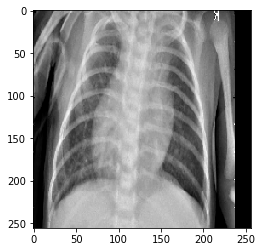

In [9]:
for i in train_generator:
    
    print(i[0][0].shape)
    plt.imshow(i[0][8], cmap='gray')
    break

In [15]:
np.unique(train_generator.classes, return_counts=True)

(array([0, 1, 2]), array([ 949, 1668,  896], dtype=int64))

In [16]:
np.unique(val_generator.classes, return_counts=True)

(array([0, 1, 2]), array([317, 556, 299], dtype=int64))

In [17]:
np.unique(test_generator.classes, return_counts=True)

(array([0, 1, 2]), array([317, 556, 298], dtype=int64))

In [18]:
n_classes = np.unique(train_generator.classes, return_counts=True)[1]

In [21]:
n_classes[0]

949

In [22]:
class_weights = {0: n_classes.sum()/n_classes[0], 1: n_classes.sum()/n_classes[1], 2: n_classes.sum()/n_classes[2]}

In [23]:
class_weights

{0: 3.7017913593256058, 1: 2.106115107913669, 2: 3.9207589285714284}

<h3> Creo el modelo </h3>

In [10]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256,256,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [11]:
model = models.Sequential()

model.add(conv_base)

model.add(layers.Flatten())

model.add(layers.Dense(1024, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Dropout(0.4))

model.add(layers.Dense(512, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Dropout(0.2))

model.add(layers.Dense(3, kernel_initializer='glorot_normal', activation='softmax'))

conv_base.trainable = False

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [13]:
%%time
model.fit_generator(train_generator,
                    class_weights=class_weights,
                    steps_per_epoch=220,
                    epochs=3,
                    validation_data=val_generator,
                    validation_steps=73)

Epoch 1/3
220/220 [==============================] - 602s 3s/step - loss: 2.1345 - accuracy: 0.7356 - val_loss: 2.4567 - val_accuracy: 0.6850
Epoch 2/3
220/220 [==============================] - 511s 2s/step - loss: 1.3255 - accuracy: 0.7680 - val_loss: 1.2355 - val_accuracy: 0.7409
Epoch 3/3
220/220 [==============================] - 501s 2s/step - loss: 1.0733 - accuracy: 0.7707 - val_loss: 1.2614 - val_accuracy: 0.7820
Wall time: 26min 55s


In [14]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    
    if layer.name in ['block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool',
                      'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool',]:
        
        set_trainable = True
        
    if set_trainable:
        
        layer.trainable = True
        
    else:
        
        layer.trainable = False
        
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

C:\Anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [15]:
opt = optimizers.RMSprop(learning_rate=1e-5, rho=0.9)

lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.1, min_delta=0.001, patience=5, cooldown=3, verbose=1)

early_stop = EarlyStopping(monitor='accuracy', mode='max', patience=10, verbose=1)

filepath="pneumonia_VGG16_weights_curso.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [16]:
%%time
history = model.fit_generator(train_generator,
                              class_weights=class_weights,
                              steps_per_epoch=220,
                              epochs=60,
                              validation_data=val_generator,
                              validation_steps=73,
                              callbacks=[lr_reduce,checkpoint,early_stop])

Epoch 1/60
220/220 [==============================] - 525s 2s/step - loss: 0.9362 - accuracy: 0.8141 - val_loss: 0.7039 - val_accuracy: 0.7814

Epoch 00001: val_accuracy improved from -inf to 0.78141, saving model to pneumonia_VGG16_weights.hdf5
Epoch 2/60
220/220 [==============================] - 530s 2s/step - loss: 0.8418 - accuracy: 0.8350 - val_loss: 1.8285 - val_accuracy: 0.7591

Epoch 00002: val_accuracy did not improve from 0.78141
Epoch 3/60
220/220 [==============================] - 558s 3s/step - loss: 0.7757 - accuracy: 0.8480 - val_loss: 0.9580 - val_accuracy: 0.7721

Epoch 00003: val_accuracy did not improve from 0.78141
Epoch 4/60
220/220 [==============================] - 541s 2s/step - loss: 0.7120 - accuracy: 0.8582 - val_loss: 0.8404 - val_accuracy: 0.7556

Epoch 00004: val_accuracy did not improve from 0.78141
Epoch 5/60
220/220 [==============================] - 531s 2s/step - loss: 0.6773 - accuracy: 0.8689 - val_loss: 0.9740 - val_accuracy: 0.7872

Epoch 00005: 

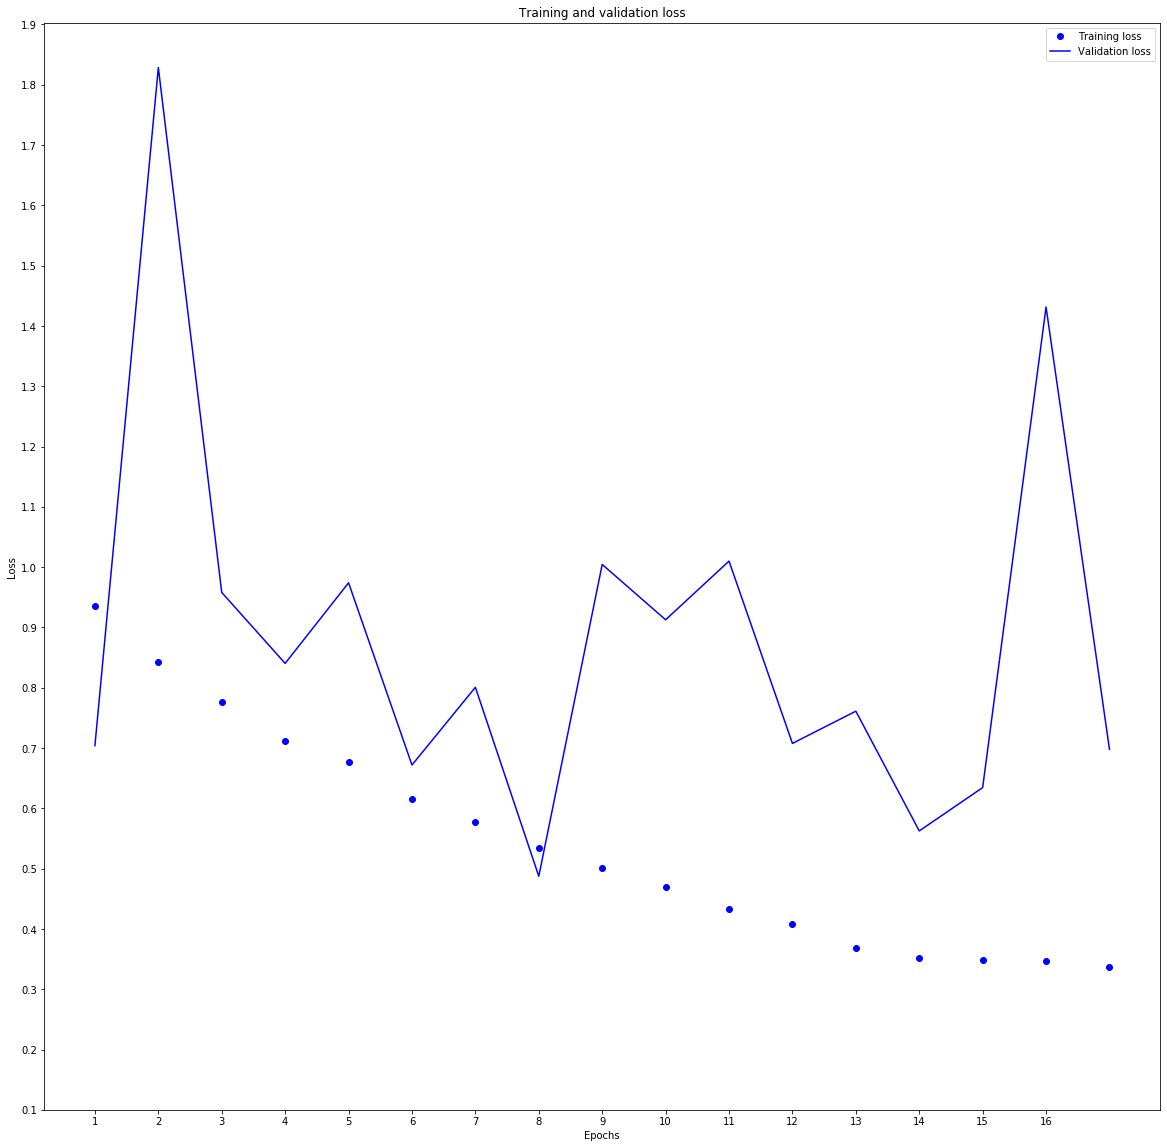

In [22]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['loss']) + 1)
plt.figure(figsize=(20,20))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(1,17,1))
plt.yticks(np.arange(0.1,2,0.1))
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

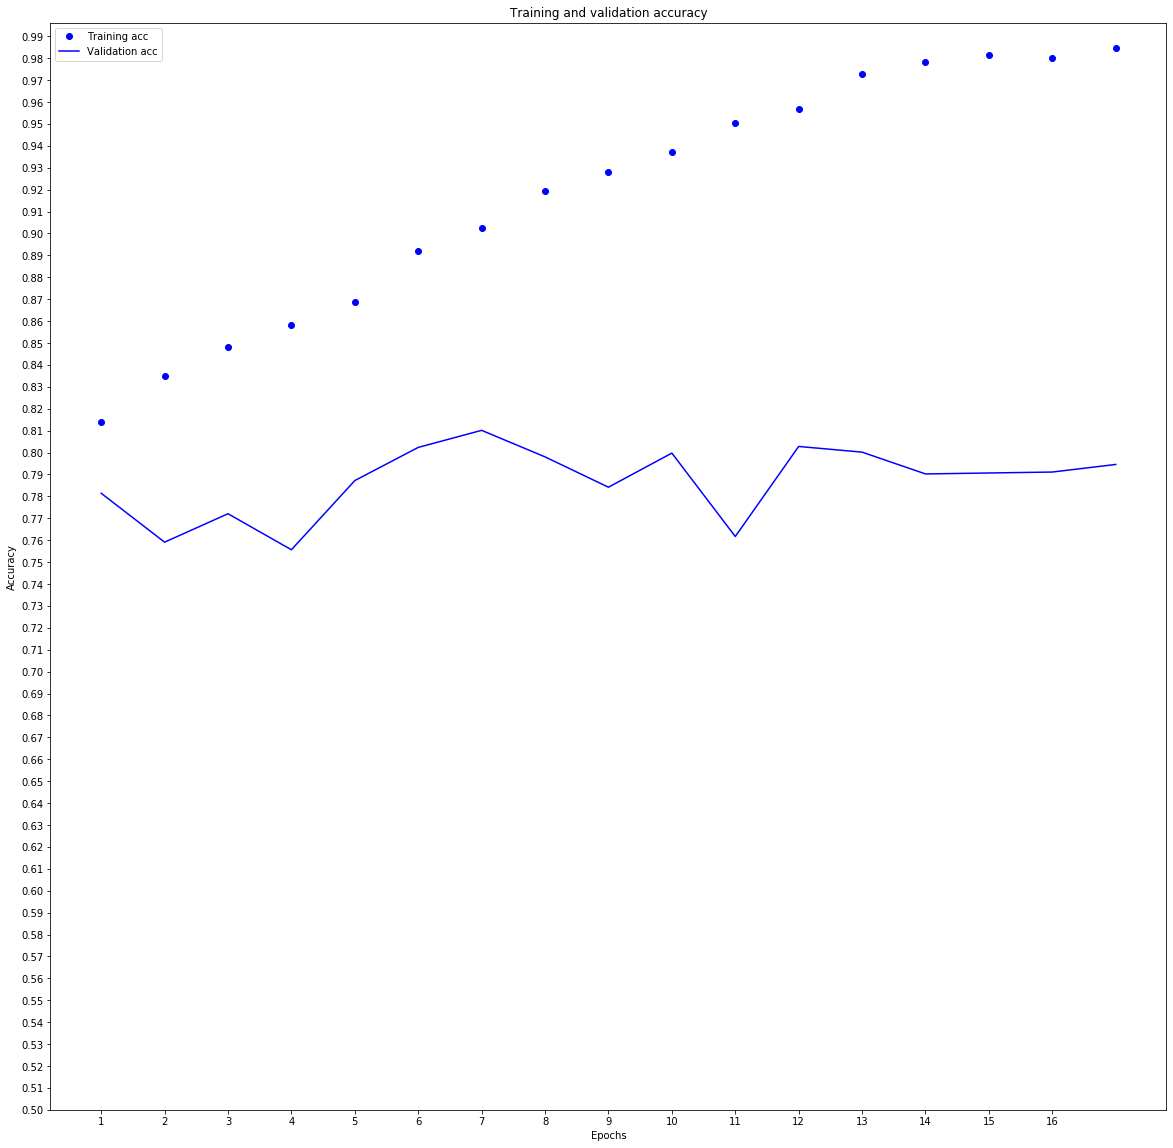

In [23]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.figure(figsize=(20,20))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1,17,1))
plt.yticks(np.arange(0.50,1,0.01))
plt.legend()
plt.show()

In [10]:
model = models.load_model("pneumonia_VGG16_weights_curso.hdf5")

In [11]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=73)
print("Resultados del test")
print("Loss: {}".format(test_loss))
print("Accuracy: {}".format(test_accuracy))

Resultados del test
Loss: 0.8477492332458496
Accuracy: 0.8075764179229736


In [12]:
j=0
for images, labels in test_generator:
    
    if j==0:
        
        y_pred = model.predict_on_batch(images)
        y_pred = np.argmax(y_pred, axis=1)
        
        y_true = np.argmax(labels, axis=1)
        
    else:
        
        y_pred = np.append(y_pred, np.argmax(model.predict_on_batch(images), axis=1))
        
        y_true = np.append(y_true, np.argmax(labels, axis=1))
    
    j+=1
    
    if j==73:
        
        break

In [13]:
score_recall = recall_score(y_true, y_pred, average='macro')

In [14]:
score_recall

0.7983006049081621

<h1> Visualization </h1>

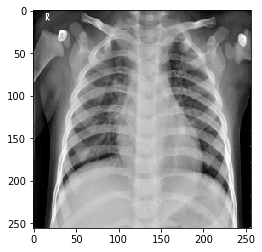

In [15]:
img=mpimg.imread(train_dir / 'BACTERIA' / 'person1_bacteria_2.JPEG')
img = transform.resize(img, output_shape=(256,256,3), preserve_range=True)
img = procesar_imagenes_gray(img)
plt.imshow(img, cmap='gray')

In [16]:
conv_model = model.layers[0]
conv_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [17]:
layer_outputs = [layer.output for layer in conv_model.layers[:] if ('block5_conv' in layer.name or 'input' in layer.name)]
layer_outputs[:]

[<tf.Tensor 'input_1:0' shape=(None, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'block5_conv1/Relu:0' shape=(None, 16, 16, 512) dtype=float32>,
 <tf.Tensor 'block5_conv2/Relu:0' shape=(None, 16, 16, 512) dtype=float32>,
 <tf.Tensor 'block5_conv3/Relu:0' shape=(None, 16, 16, 512) dtype=float32>]

In [18]:
activation_model = models.Model(inputs=layer_outputs[0], outputs=layer_outputs[1:])

In [19]:
activations = activation_model.predict(np.expand_dims(img, axis=0))

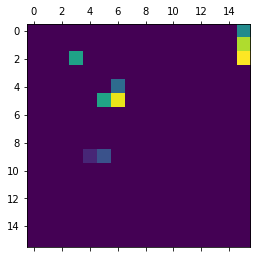

In [20]:
plt.matshow(activations[1][0][:,:,4], cmap='viridis')

In [21]:
model.input

<tf.Tensor 'vgg16_input:0' shape=(None, 256, 256, 3) dtype=float32>

In [22]:
layer_names = []
for layer in layer_outputs:
    
    if 'conv' in layer.name:
        
        layer_names.append(layer.name)

In [23]:
layer_names

['block5_conv1/Relu:0', 'block5_conv2/Relu:0', 'block5_conv3/Relu:0']

In [24]:
len(activations)

3

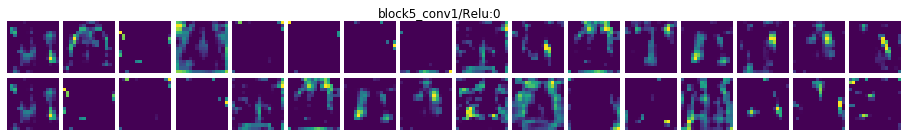

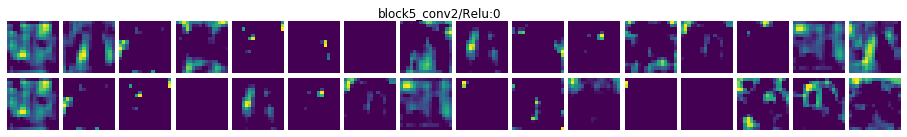

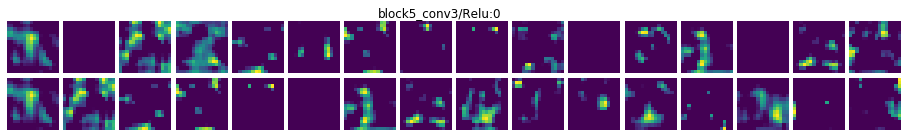

In [25]:
for i,layer in enumerate(activations):
    
    fig = plt.figure(figsize=(16,2))
    gs = fig.add_gridspec(2, 16, wspace=0.1, hspace=0.1)
    fig.suptitle(layer_names[i])
    
    for row in range(2):
        
        for col in range(16):
            
            axe = fig.add_subplot(gs[row,col])
            plt.axis('off')
            axe.matshow(layer[0,:,:,row*col + col], aspect='auto',cmap='viridis')

<h3> Filter visualization </h3>

In [41]:
layer_names = [layer.name for layer in conv_model.layers[:] if 'block3_conv' in layer.name]
n_filters_of_layer = {layer_name : 16 for layer_name in layer_names}

In [42]:
layer_names

['block3_conv1', 'block3_conv2', 'block3_conv3']

In [43]:
def process_image(iterate):
    
    input_img_data = np.random.random((1,150,150,3)) * 20 + 128

    step = 1
    for i in range(100):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    return input_img_data[0]

In [44]:
def deprocess_image(x):
    
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

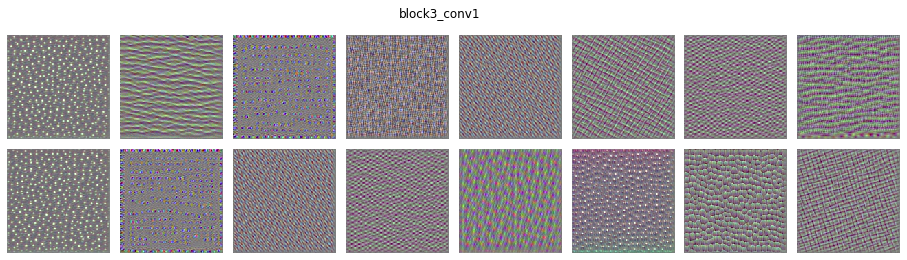

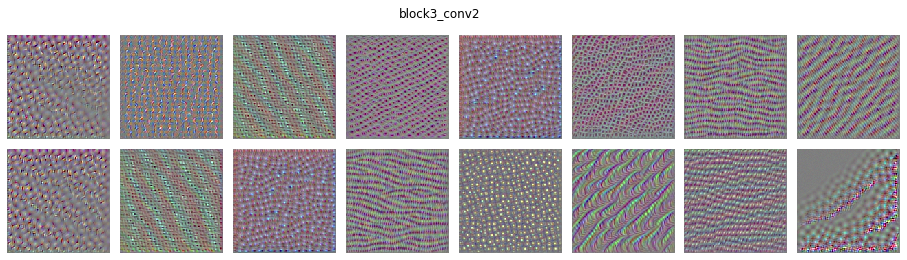

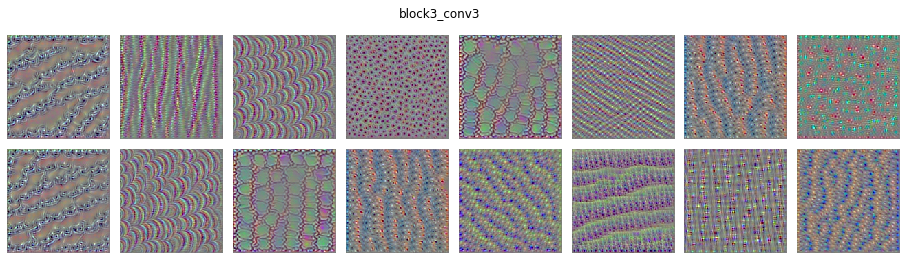

In [45]:
for layer in layer_names:
    
    fig = plt.figure(figsize=(8*2,2*n_filters_of_layer[layer]//8))
    gs = fig.add_gridspec(n_filters_of_layer[layer]//8, 8, wspace=0.1, hspace=0.1)
    fig.suptitle(layer)
    
    for row in range(n_filters_of_layer[layer]//8):
        
        for col in range(8):
            
            axe = fig.add_subplot(gs[row,col])
            plt.axis('off')
            
            layer_output = conv_model.get_layer(layer).output
            loss = K.mean(layer_output[:,:,:,row*col + col])
            
            grads = K.gradients(loss, layer_outputs[0])[0]
            grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
            
            iterate = K.function([layer_outputs[0]], [loss, grads])
            filtro = deprocess_image(process_image(iterate))
            
            axe.matshow(filtro, aspect='auto')